# Random Forest Classifier

Random forest classifiers utilize numerous decision trees during training and output a classifcation which is the average prediction of the trees in the forest. 

Advantages of random forests:
    - give estimates of what variables are important in the classification
    - contain methods for balancing error for unbalanced data sets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
raw_data = pd.read_csv('rodpump_noImputed.csv', parse_dates=['lifetime_end'])

In [3]:
# function that converts categorical features into numerics
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
def encode_categorical(df, columnName):
    df[columnName] = labelencoder.fit_transform(df[columnName])
    return df

In [4]:
raw_data = encode_categorical(raw_data, 'bha_configuration')
raw_data = encode_categorical(raw_data, 'wellbore_category')
raw_data = encode_categorical(raw_data, 'packer_vs_tac')
raw_data = encode_categorical(raw_data, 'rod_sinker_type')
raw_data = encode_categorical(raw_data, 'manual_scale')
raw_data = encode_categorical(raw_data, 'rod_make')
raw_data = encode_categorical(raw_data, 'rod_apigrade')
raw_data = encode_categorical(raw_data, 'FAILURETYPE')

In [5]:
features = ['PrimarySetpoint','SecondarySetpoint','H2S_CONCENTRATION','StrokeLength','bha_configuration','max_unguided_dls','dls_high_in_hole','MAX_INCLINATION','AVG_PRESSURE_TUBING','AVG_PRESSURE_CASING','AVG_DIFFERENTIAL_PRESSURE','AVG_OIL_VOLUME','AVG_WATER_VOLUME','AVG_LIQUID_VOLUME','overall_max_sideload','shallow_max_sideload','max_unguided_sideload','wellbore_category','packer_vs_tac','rod_sinker_type','manual_scale','rod_has_guides','rod_apigrade']

In [6]:
# X = the data (features) that will be used to predict failure type (y)
X = np.array(raw_data[features])

In [7]:
# y = target variable (what we want to predict)
y = np.array(raw_data['FAILURETYPE'])

In [8]:
# divide our dataset into training and testing subsets with an 80% to 20% split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
rf_base = RandomForestClassifier()
rf_base.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
rf_base.score(X_train,y_train)

1.0

In [11]:
rf_base.score(X_test,y_test)

0.6451612903225806

# Tune Hyperparameters to optimize the model

Hyperparameters are the variables used to split each node during the process of training the data. Examples of hyperparameters include the number of decision trees in the forest and the number of features considered by each tree when splitting a node.

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them on the training data, and return the values that perform the best.

In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [13]:
# Hyperparameter grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 4, stop = 10, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [14]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [15]:
rf_model = RandomForestClassifier()

In [16]:
rf_random = RandomizedSearchCV(rf_model, random_grid, n_iter = 10, cv = 3, verbose = 2, n_jobs = 4)

In [17]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.3s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 6, 8, 9, 11, 13, 14,
                                                      16, 18, 20, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [4, 4, 5, 6, 6, 7, 8, 8,
                                                         9, 10]},
                   verbose=2)

In [18]:
rf_random.best_params_

{'n_estimators': 6,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 4,
 'bootstrap': True}

In [19]:
# Use the best hyperparameters to build a better model
better_model = rf_random.best_estimator_

# Random Forest Classifier Results

In [20]:
better_model.score(X_train,y_train)

0.6720516962843296

In [21]:
better_model.score(X_test,y_test)

0.6

In [22]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2  2 18]
 [ 0  4 37]
 [ 0  5 87]]


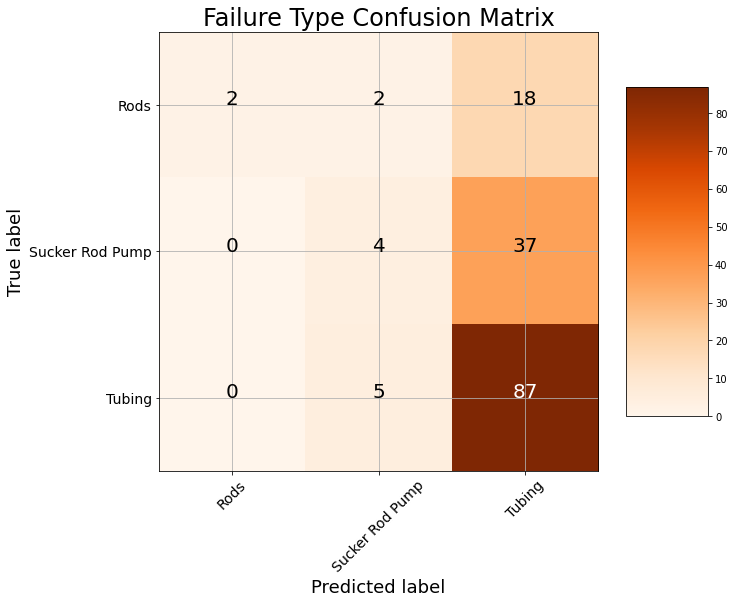

In [23]:
cm = confusion_matrix(y_test, better_model.predict(X_test))
plot_confusion_matrix(cm, classes = ['Rods', 'Sucker Rod Pump', 'Tubing'],
                      title = 'Failure Type Confusion Matrix')

# future: utilize class weighting and random undersampling to combat imbalanced classification

# Insight into which features might be important in predicting failure type

Importance values are calculated by summing the reduction in Gini Impurity (the probability of classifying incorrectly) over all of the nodes of the tree in which the feature is used.

Features with low importance do not contribute much to the prediction of failure type. This means that we can remove this feature and train our random forest classifier again. Then, we can see if the model improved in performance.

In [24]:
b_model = pd.DataFrame({'feature': features,
                   'importance': better_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

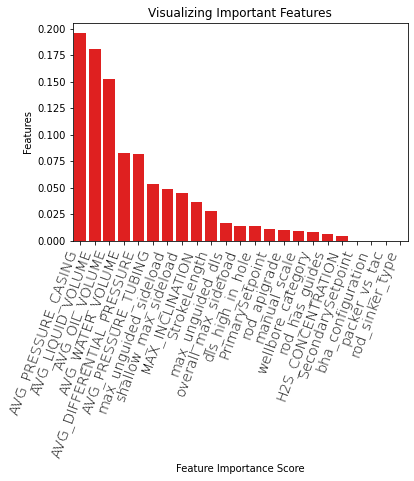

In [25]:
# visualize important features

sns.barplot(x=b_model.feature, y=b_model.importance, color = 'r')

plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.xticks(
    rotation=70, horizontalalignment="right", fontweight="light", fontsize="x-large"
)
plt.show()